In [1]:
import os
import re
import json
import collections
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pprint import pprint
from customer_behaviour.tools import dgm as dgm
from customer_behaviour.tools import time_series_analysis

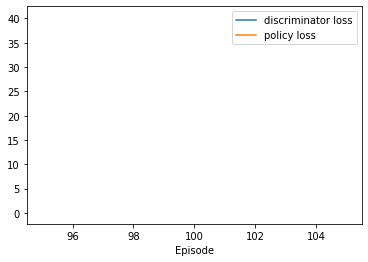

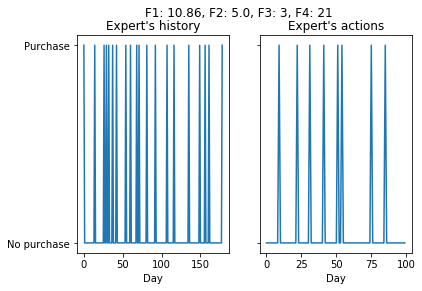

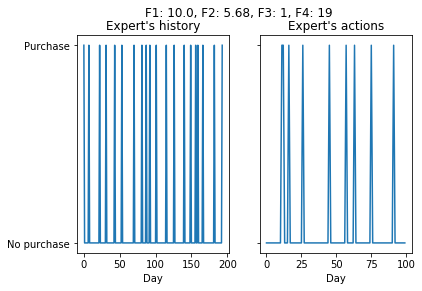

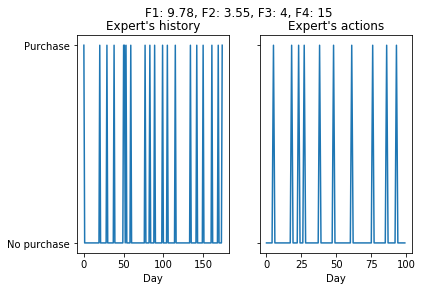

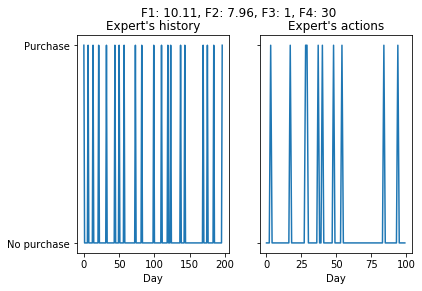

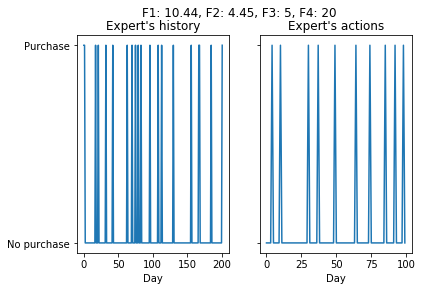

In [7]:
datetime = '2020-02-17_14-15-34'
dir_path = '/results/gail/discrete_events/1_expert(s)/case_3/' + datetime


result = Case3(dir_path)
result.plot_loss()
result.plot_trajectories(n_trajectories=5, expert=True)

In [6]:
############################
########## Case 3 ##########
############################

class Case3(Result):
    # There is only one expert
    # State representation: [days elapsed since last purchase, 
    #                        days elapsed between last purchase and the purchase before that, ...]
    
    def __init__(self, dir_path):
        Result.__init__(self, dir_path)
        
        self.n_expert_trajectories = self.expert_states.shape[0]
        
        self.n_learner_trajectories, self.episode_length, _ = self.learner_states.shape
        self.n_historical_events = self.learner_states.shape[2]
    
    def plot_trajectories(self, n_trajectories=None, expert=False):
        if n_trajectories is None: 
            n_trajectories = self.n_expert_trajectories if expert else self.n_learner_trajectories
        
        for i in range(n_trajectories):
            if expert:
                states = self.expert_states[i]
                actions = self.expert_actions[i]
            else:
                states = self.learner_states[i]
                actions = self.learner_actions[i]
            
            history = self.get_history(states[0])
            
            fig = self.plot(history, actions, expert)
            
            tsa = time_series_analysis.TimeSeriesAnalysis(actions)
            mean_freq, std_freq = tsa.get_mean_std_freq()
            min_elapsed_days, max_elapsed_days = tsa.get_min_max_elapsed_days()

            features = [round(mean_freq[0], 2), round(std_freq[0], 2), \
                        min_elapsed_days[0], max_elapsed_days[0]]
            
            fig.suptitle('F1: {}, F2: {}, F3: {}, F4: {}'.format(*features))
            
        plt.show()
        fig.tight_layout()
            
    def get_history(self, initial_state):
        history = []
        for x in initial_state:
            while x > 1:
                history.append(0)
                x -= 1
            history.append(1)
        history.reverse()
        return history
               
    def plot(self, history, actions, expert=False):
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row')
        ax1.plot(history)
        ax2.plot(actions)
            
        # Set titles
        if expert:
            ax1.set_title("Expert's history")
            ax2.set_title("Expert's actions")
        else:
            ax1.set_title("Learner's history")
            ax2.set_title("Learner's actions")
            
        # Set x-labels
        ax1.set_xlabel('Day')
        ax2.set_xlabel('Day')

        # Set y-labels
        ax1.set_yticks([0, 1])
        ax1.set_yticklabels(['No purchase', 'Purchase'])
        
        return fig

############################
########## Case 2 ##########
############################ 

class Case2(Result):
    # There is only one expert
    # State representation: [historical purchases]
    
    def __init__(self, dir_path):
        Result.__init__(self, dir_path) 
        
        self.n_learner_trajectories, self.episode_length, _ = self.learner_states.shape
        self.n_historical_events = self.learner_states.shape[2]
    
    def plot_trajectories(self, n_trajectories=None):
        expert_states = self.expert_states[0]
        expert_actions = self.expert_actions[0]
        expert_history = expert_states[0][:]
        
        if n_trajectories is None: n_trajectories = self.n_learner_trajectories
        
        for i in range(n_trajectories):
            states = self.learner_states[i]
            actions = self.learner_actions[i]
            history = states[0][:]
                
            fig = self.plot(expert_history, expert_actions, history, actions)  
            fig.suptitle('Demonstration #{}'.format(i+1))
                         
        fig.tight_layout()
        plt.show()

############################
########## Case 1 ##########
############################
        
class Case1(Result):
    # There is only one expert
    # State representation: [sex, age, historical purchases]
    
    def __init__(self, dir_path):
        Result.__init__(self, dir_path) 
        
        # assert self.expert_states.shape[0] == 1
        
        self.n_learner_trajectories, self.episode_length, _ = self.learner_states.shape
        self.n_historical_events = self.learner_states.shape[2] - 2
    
    def plot_trajectories(self, n_trajectories=None):
        expert_states = self.expert_states[0]
        expert_actions = self.expert_actions[0]
        expert_sex = expert_states[0][0]
        expert_age = expert_states[0][1]
        expert_history = expert_states[0][2:]
        
        if n_trajectories is None: n_trajectories = self.n_learner_trajectories
        
        for i in range(n_trajectories):
            states = self.learner_states[i]
            actions = self.learner_actions[i]
            sex = states[0][0]
            age = states[0][1]
            history = states[0][2:]
            
            expert_sex_str = 'female' if expert_sex == 1 else 'male'
            sex_str = 'female' if sex == 1 else 'male'
            text = 'Expert: {}, {} years old | Learner: {}, {} years old'.format(
                expert_sex_str, get_age(expert_age), sex_str, get_age(age))
                
            fig = self.plot(expert_history, expert_actions, history, actions)  
            fig.suptitle('Demonstration #{}'.format(i+1))
            fig.text(0.5, 0, text, horizontalalignment='center', verticalalignment='center')
                         
        fig.tight_layout()
        plt.show()


In [5]:
#################################
########## Super class ##########
#################################

class Result():
    def __init__(self, dir_path):
        self.expert_data = os.getcwd() + dir_path + '/expert_trajectories.npz'
        self.learner_data = os.getcwd() + dir_path + '/trajectories.npz'
        self.action_probs_path = os.getcwd() + dir_path + '/action_probs.npz'
        self.scores_path = os.getcwd() + dir_path + '/scores.txt'
        self.args_path = os.getcwd() + dir_path + '/args.txt'
        
        self.action_probs = self.load_action_probs(self.action_probs_path) if os.path.exists(self.action_probs_path) else None
        self.expert_states, self.expert_actions = self.load_data(self.expert_data)
        self.learner_states, self.learner_actions = self.load_data(self.learner_data)
    
    def load_data(self, file):
        data = np.load(file, allow_pickle=True)
        assert sorted(data.files) == sorted(['states', 'actions'])

        states = data['states']
        actions = data['actions']

        return states, actions

    def load_action_probs(self, path):
        data = np.load(path, allow_pickle=True)
        assert sorted(data.files) == sorted(['action_probs'])
        return data['action_probs']

    def plot_loss(self):
        discriminator_loss, policy_loss = self.read_scores_txt()
        args = self.read_args_txt()
        n_episodes = args["n_training_episodes"]
        episode_length = args["episode_length"]
        
        # logs info every 10 000th step
        delta_episode = int(10000/episode_length)
        x = range(delta_episode, n_episodes + delta_episode, delta_episode)
        plt.plot(x, discriminator_loss, label='discriminator loss')
        plt.plot(x, policy_loss, label='policy loss')
        plt.xlabel('Episode')
        plt.legend()
        plt.show()

    def read_scores_txt(self):
        file_obj = open(self.scores_path,"r") 
        lines = file_obj.readlines()
        discriminator_loss = []
        policy_loss = []
        for idx, line in enumerate(lines):
            if idx > 0: # We do not want the column names
                line1 = line.split(" ")[0]
                line2 = re.split(r'\t+', line1)
                discriminator_loss.append(float(line2[8]))
                policy_loss.append(float(line2[-1].rstrip("\n\r")))
        return discriminator_loss, policy_loss

    def read_args_txt(self):
        return json.loads(open(self.args_path,"r").read())
    
    def plot(self, expert_history, expert_actions, learner_history, learner_actions):        
        fig, axes = plt.subplots(2, 2, sharex='col', sharey='row')
        
        ax11 = axes[0, 0]
        ax12 = axes[0, 1]
        ax21 = axes[1, 0]
        ax22 = axes[1, 1]

        ax11.plot(expert_history)
        ax12.plot(expert_actions)
        ax21.plot(learner_history)
        ax22.plot(learner_actions)
        
        # Set titles
        ax11.set_title("Expert's history")
        ax12.set_title("Expert's actions")
        ax21.set_title("Learner's history")
        ax22.set_title("Learner's actions")
        
        # Set x-labels
        ax21.set_xlabel('Day')
        ax22.set_xlabel('Day')
        
        # Set y-labels
        ax11.set_yticks([0, 1])
        ax11.set_yticklabels(['No purchase', 'Purchase'])
        ax21.set_yticks([0, 1])
        ax21.set_yticklabels(['No purchase', 'Purchase'])
        
        return fig

########################################
########## Helper function(s) ##########
########################################

def get_age(age):
    if age < 0.2:
        return '18-29'
    elif age < 0.4:
        return '30-39'
    elif age < 0.6:
        return '40-49'
    elif age < 0.8:
        return '50-59'
    elif age < 1.0:
        return '60-69'
    else:
        return '70-80'
